Rayleigh Taylor instability
======

This tutorial builds a model of the classic Rayleigh Taylor instability. See [here](https://en.wikipedia.org/wiki/Rayleigh%E2%80%93Taylor_instability) for more details on the RT instability. To benchmark the underworld code this notebook also provides a direct comparison to the isoviscous thermochemical convection benchmark values from van Keken *et al.* (1997). The system of equations is given by

$$
    \nabla \cdot \left( \eta \nabla \dot\varepsilon \right) - \nabla p = 
    \left( Ra _T T + Ra _\Gamma \Gamma \right) \mathbf{\hat z}
$$

$$
    \nabla \cdot \mathbf{v} = 0
$$

The thermal and compositional evolution is controlled by advection and (thermal) diffusion

$$
    \frac{D T}{D t} = \nabla^2 T 
$$    

$$
    \frac{D \Gamma}{D t} = 0
$$

Thermal and compositional Rayleigh numbers are defined by

$$ 
    Ra _T = \frac{g \rho \alpha \Delta T h ^3}{\kappa \eta _r} ; \;\;\;\; 
    Ra _\Gamma = \frac{g \Delta \rho _\Gamma h ^3}{\kappa \eta _r}
$$



**Lesson concepts:**
1. More on particle swarms.
2. Producing snapshot images to file (which can then be made into a movie).
3. Comparison of benchmark values.

**Keywords:** particle swarms, Stokes system, advective diffusive systems

**References**

1. van Keken, P.E., S.D. King, H. Schmeling, U.R. Christensen, D.Neumeister and M.-P. Doin. A comparison of methods for the modeling of thermochemical convection. Journal of Geophysical Research, 102, 22,477-22,495, 1997.  
http://onlinelibrary.wiley.com/doi/10.1029/97JB01353/abstract


In [1]:
%matplotlib inline
import matplotlib.pyplot as pyplot
import matplotlib.pylab as pylab
import numpy as np
import underworld as uw
import math
from underworld import function as fn
import glucifer

Setup parameters
-----

Set simulation parameters. The box length is chosen for direct comparison to the benchmark values.

In [2]:
res = 64
boxLength = 0.9142
boxHeight = 1.0

Here we also set the viscosity of the light material ($\eta \leq$ 1) relative to the reference heavy material ($\eta_r = 1$) which is used when we set up the parameters and functions below. This is set to be $\eta =$ 1, 0.1 and 0.01 for the 3 cases given in van Keken *et al.* 1997.

In [3]:
eta = 1.0

**Input/output paths**

Set input and output file directory paths. Input files are previous $v_{rms}$ and $Nu$ numbers as a function of time. The output path directory will contain the resulting $v_{rms}$ and $Nu$ data as well as the image snap shots.

In [4]:
inputPath  = 'RTInput/'
outputPath = 'RTOutput/'
# Make output directory if necessary
import os
if not os.path.exists(outputPath):
    os.makedirs(outputPath)

Create mesh and finite element variables
------

In [5]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = (res, res), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (boxLength, boxHeight))

velocityField = uw.fevariable.FeVariable( feMesh=mesh,         nodeDofCount=2 )
pressureField = uw.fevariable.FeVariable( feMesh=mesh.subMesh, nodeDofCount=1 )

# Create a particle swarm
------

Swarms refer to (large) groups of particles which can advect with the fluid flow. These can be used to determine 'materials' as they can carry local information such as the fluid density and viscosity.

**Setup a swarm**

To set up a swarm of particles the following steps are needed:
1. Initialise a swarm.
2. Define data variable to store an index that will state what material a given particle is.
3. Populate the swarm over the whole domain using the layout command.

In [6]:
# Initialise a swarm.
swarm = uw.swarm.Swarm( feMesh=mesh )

# Add a data variable which will store an index to determine material.
materialVariable = swarm.add_variable( dataType="int", count=1 )

# Create a layout object that will populate the swarm across the whole domain.
swarmLayout = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=swarm, particlesPerCell=20 )

# Populate.
swarm.populate_using_layout( layout=swarmLayout )

**Allocate each particle a material index**

Each particle in the swarm can be given individual values, such as viscosity and density. The concept of materials is used in underworld to create groups of particles which have similar behaviour.

The example below sets particles of the swarm to be one of two materials based on the initial particle position in the system. It distinguishes between the positions using the condition 
\\[
0.2 + \cos \left( \frac{2 \pi x}{\lambda} \right) > z
\\]
to have the light material index. Here the notation is adopted of $z$ for coordinate[1], $x$ for coordinate[0] and $\lambda$ for the wavelength. If this condition is not satisfied then the particle will be labelled by the heavy index, as this final condition is always true. For further details, please refer to the user guide and/or docstrings.

Later these materials are given specific densities and viscosities.

In [7]:
# Initialise the 'materialVariable' data to represent two different materials. 
denseIndex = 0
lightIndex = 1

# The form of this perturbation is taken from van Keken et al. 1997
wavelength = 2.0*boxLength
amplitude  = 0.02
offset     = 0.2
k = 2. * math.pi / wavelength

# The particle coordinates will be the input to the function evaluate (see final line in this cell).
# We get proxy for this now using the input() function.
coordinate = fn.input()

# Define our perturbation function. Note that it is a function of the x coordinate, 
# accessed by 'coordinate[0]'.
perturbationFn = offset + amplitude*fn.math.cos( k*coordinate[0] )

# Setup the conditions list for the following conditional function. Where the
# z coordinate (coordinate[1]) is less than the perturbation, set to lightIndex.
conditions = [ ( perturbationFn > coordinate[1] , lightIndex ),
               (                           True , denseIndex ) ]

# The actual function evaluation. Here the conditional function is evaluated at the location
# of each swarm particle. The results are then written to the materialVariable swarm variable.
materialVariable.data[:] = fn.branching.conditional( conditions ).evaluate(swarm)

**Plot the particles by material**

Setup a standard method for plotting all particles in a swarm with colour set by the material index (light or heavy).


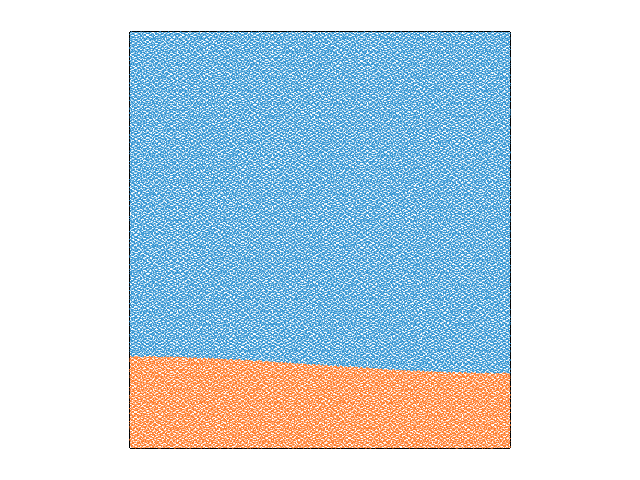

In [8]:
fig1 = glucifer.Figure()
fig1 + glucifer.objects.Points( swarm, materialVariable, pointSize=2, colourBar=False )
fig1.show()

Set up material parameters and functions
-----

Here the functions for density, viscosity etc. are set. These functions and/or values are preserved for the entire simulation time. 

The Map function allows us to create 'per material' type behaviour. Again we use the branching function to set up a (condition, action) command, which in this case uses uses the materialVariable to distinguish which value to use for the density or viscosity for each swarm particle.


In [9]:
# Here we set a density of '0.' for the lightMaterial, and '1.' for the heavymaterial.
densityMap   = { lightIndex:0., denseIndex:1. }
densityFn    = fn.branching.map( keyFunc = materialVariable, mappingDict = densityMap )

# Here we set a viscosity value of '1.' for both materials.
viscosityMap = { lightIndex:eta, denseIndex:1. }
viscosityFn  = fn.branching.map( keyFunc = materialVariable, mappingDict = viscosityMap )

# Define our vertical unit vector using a python tuple (this will be automatically converted to a function).
z_hat = ( 0.0, 1.0 )

# Now create a buoyancy force vector using the density (FEvariable) and the vertical unit vector. 
buoyancyFn = -densityFn*z_hat

System Setup
----------

**Initialise variables**


In [10]:
velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.

**Conditions on the boundaries**

Construct sets for the both horizontal and vertical walls to define conditons for underworld solvers. Here we effectively create a free-slip condition on the left and right boundaries, and a no-slip condition on the top and bottom.

In [11]:
# We extract various sets of boundary nodes here.
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
allWalls = iWalls + jWalls

# Now, using these sets, decide which degrees of freedom (on each node) should be considered Dirichlet.
stokesBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                             nodeIndexSets = (allWalls, jWalls) )

**Create a Stokes system**

In [12]:
stokesPIC = uw.systems.Stokes( velocityField = velocityField, 
                               pressureField = pressureField,
                               swarm         = swarm, 
                               conditions    = [stokesBC,],
                               viscosityFn   = viscosityFn, 
                               bodyForceFn   = buoyancyFn )

**Create a system to advect the particles**


In [13]:
advector = uw.systems.SwarmAdvector( swarm=swarm, velocityField=velocityField, order=2 )

Analysis tools
-----

**RMS velocity**

Set up integrals used to calculate the RMS velocity.

In [14]:
vdotv = fn.math.dot(velocityField,velocityField)
v2sum_integral  = uw.utils.Integral( mesh=mesh, fn=vdotv )
volume_integral = uw.utils.Integral( mesh=mesh, fn=1. )

Main simulation loop
-----
Inside the loop the Stokes system is solved at each step, with the resulting velocity field used to advect the swarm.

In [15]:
# Stepping. Initialise time and timestep.
time         = 0.
steps        = 0
timeEnd      = 300  # generally you will want to run for around 300 
outputEvery  = 20
timeVal     = []
vrmsVal     = []

**Outputting snapshot images during loop**

Create visualisation object to output to file after every time step. This will output a raster image file within the directory specified in the outputPath variable. These files can be stitched together to create an animation.

A comparison animation is included in the input path directory.

**Output to xdmf files**

Setup the fields that we want to output in xdmf files. These will be put in the ``outputPath`` directory every time we call ``uw.utils.xdmf_write``.

In [16]:
# this dictional gives textual names to field variables
outputField = { 'velocity' : velocityField,
                'pressure' : pressureField }

Run time loop until $v_{rms}$ is expected to settle; t = 2000 taken from van Keken *et al.* 1997.

In [17]:
while time<timeEnd:
    # Get solution for initial configuration.
    stokesPIC.solve()
    # Retrieve the maximum possible timestep for the advection system.
    dt = advector.get_max_dt()
    # Advect using this timestep size.
    advector.integrate(dt)
    # Calculate the RMS velocity.
    vrms = math.sqrt( v2sum_integral.evaluate()[0] / volume_integral.evaluate()[0] )
    # Store values in variables.
    vrmsVal.append(vrms)
    timeVal.append(time)
    # print output
    if steps%outputEvery == 0:
        print 'step = {0:6d}; time = {1:.3e}; v_rms = {2:.3e}'.format(steps,time,vrms)
    # output hdf5 files as well as append xdmf file
        uw.utils.xdmf_write( outputField, mesh, time=time, outputDir=outputPath )
    # output snapshot of particles to figure.
        outputFilename = outputPath+"image"+str(steps).zfill(4)
        fig1.save_image(outputFilename)
    time += dt
    steps += 1
print 'step = {0:6d}; time = {1:.3e}; v_rms = {2:.3e}'.format(steps,time,vrms)

step =      0; time = 0.000e+00; v_rms = 1.849e-04
step =     20; time = 1.371e+02; v_rms = 1.019e-03
step =     40; time = 1.703e+02; v_rms = 1.888e-03
step =     60; time = 1.903e+02; v_rms = 2.590e-03
step =     80; time = 2.065e+02; v_rms = 3.016e-03
step =    100; time = 2.214e+02; v_rms = 3.121e-03
step =    120; time = 2.365e+02; v_rms = 2.948e-03
step =    140; time = 2.531e+02; v_rms = 2.587e-03
step =    160; time = 2.726e+02; v_rms = 2.170e-03
step =    180; time = 2.957e+02; v_rms = 1.809e-03
step =    184; time = 3.008e+02; v_rms = 1.761e-03


Post simulation analysis
-----

Plot final swarm positions.



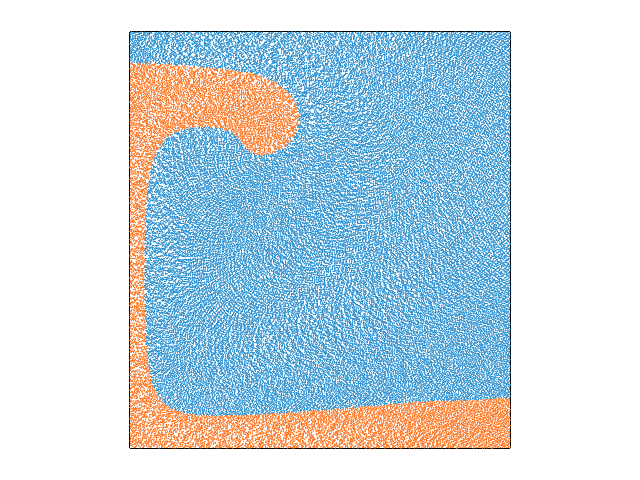

In [18]:
fig1.show()

#### **Save RMS velocity data**

Save time and $v_{rms}$ to file using numpy. This will create a text file with two rows in the format:

    time(0), vrms(0)
    time(1), vrms(1)
    ...
    time(N), vrms(N)


In [19]:
np.savetxt( outputPath+'RT_vms.out', np.c_[timeVal, vrmsVal], header="Time VRMS" )

**Check data against benchmark values**

Perform an analysis of the $v_{rms}$ values against time to find the maximum $v_{rms}$, the time at which this maximum occurs and the growth rate. The growth rate ($\gamma$) is calculated by solving 
$$
    v_{rms}(t) = v_{rms}(0) \exp ( \gamma t )
$$
for $\gamma$ where the time chosen is half the time at maximum $v_{rms}$.

In [20]:
maxVrms = 0.0
maxTime = 0.0
maxIndex = 0
index = 0

for time in timeVal:
    vrms = vrmsVal[index]
    if(vrms > maxVrms):
        maxVrms  = vrms
        maxTime  = time
        maxIndex = index
    index += 1

# Calculate growth rate.
vZero = vrmsVal[0]
vRms  = vrmsVal[maxIndex/2]
tHalf = timeVal[maxIndex/2]
if(tHalf>0.0):
    gamma = math.log(vrms/vZero)/tHalf
else:
    gamma = math.log(vrms/vZero)
print('Viscosity ratio = {0:.2f}'.format(eta))
print('    Growth rate = {0:.4f}'.format(gamma))
print('    t(max vrms) = {0:.2f}'.format(maxTime))
print('           vrms = {0:.4f}'.format(maxVrms))

Viscosity ratio = 1.00
    Growth rate = 0.0126
    t(max vrms) = 218.39
           vrms = 0.0031


The benchmark values from van Keken *et al.* 1997 are approximately:

| Viscosity ratio ($\frac{\eta}{\eta_r}$) |  Growth rate ($\gamma$)  |  t (max $v_{rms}$) | max $v_{rms}$ |
| :-------------:  | :-----------: | :----------------: | :-----------: |
| 1.00            | 0.0112        | 208.99             | 0.0031 |
| 0.10            | 0.0459        | 71.92              | 0.0095 |
| 0.01            | 0.1042        | 49.57              | 0.0146 |

Note that these are based on high resolution and the precise values depending on the size of the time step chosen. In this example the largest timestep for the advection-diffusion solver possible is chosen. So there will be discrepancy between the values from underworld and the benchmark values.

**Load previous RMS velocity data**

Load velocity and time data from a pre-run simulation for this viscosity ($\eta$) value. These were run using underworld and so should be exactly the same as those run here.

In [21]:
if(eta == 1.0):
    data = np.loadtxt(inputPath+'VrmsCaseA.txt', unpack=True )
elif(eta == 0.1):
    data = np.loadtxt(inputPath+'VrmsCaseB.txt', unpack=True )
elif(eta == 0.01):
    data = np.loadtxt(inputPath+'VrmsCaseC.txt', unpack=True )
else:
    print('No specific data found - default to Case A')
    data = np.loadtxt(inputPath+'VrmsCaseA.txt', unpack=True )

# Load them into data arrays to compare with timevals and vrmsvals from above.
timeCompare, vrmsCompare = data[0], data[1] 
# These can be copied onto timevals and vrmsvals to skip running the time loop.

**Plot RMS velocity**

Plot the RMS velocity from the simulation run here (red) against the pre-run RMS velocity (black) against time. These should overlap.

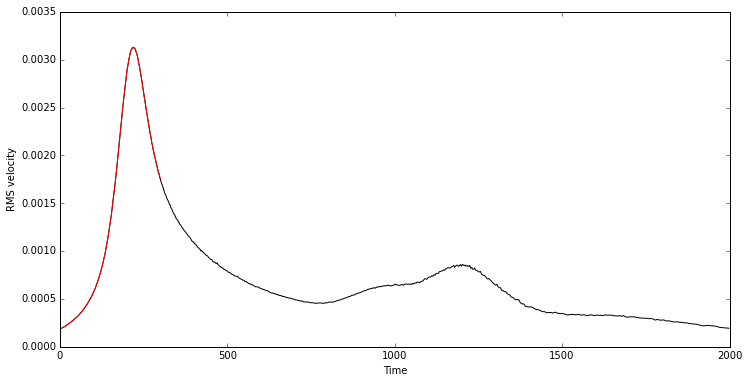

In [22]:
pylab.rcParams[ 'figure.figsize'] = 12, 6
pyplot.plot(timeCompare, vrmsCompare, color = 'black') 
pyplot.plot(timeVal, vrmsVal, color = 'red') 
pyplot.xlabel('Time')
pyplot.ylabel('RMS velocity')
pyplot.show()